# Assignment: Risk predicition of criminal re-offense



**This notebook** presents an exploration of a sub-set of data from **[SAVRY](https://www.parinc.com/Products/Pkey/390)** (Structured Assessment of Violence Risk in Youth) applied to young offenders in Catalonia. 

SAVRY is a risk assessment tool, that supports structured professional judgement. SAVRY contains 24 risk factors, in which each item (variables `V65*` to `V88*`) can have one of three values (low=0, moderate=1, high=2), for a total score between 0 and 48 points. 

+ Human score: There is also a score by a professional (variable `V56_@R1_resum_risc_global_reverse`) that can be low, moderate, or high. 
+ Recividism: In this dataset, there is information about whether people committed a new crime after the evaluation.  The variable `V115_reincidencia_2015` represents Recidivism (year 2015).
+ The variable `V60_SAVRY_total_score` contains a sum of scores in the risk items of SAVRY. This score can be seen as a baseline automatic method.

Features values can be found in ``reincidenciaJusticiaMenors.xlsx``. The description of features can be found in ``recidivismJuvenileJustice_variables_EN.pdf``. The data file we use is a subset of data obtained by the Centre d'Estudis Jurídics i Formació Especialitzada of the Catalan government and released in 2017.

The objectives of this assignment are: 
+ To compare the performance of SAVRY and ML-based methods, in terms of both performace and fairness metrics. 
+ To analyze the causes of unfairness.
+ To explore a mitigation strategy.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc

### Data Exploration

In [2]:
FILENAME_DATASET = 'reincidenciaJusticiaMenors.xlsx'

df = pd.read_excel(FILENAME_DATASET)
df.head()

,id,V1_sexe,V2_estranger,V3_nacionalitat,V4_nacionalitat_agrupat,V5_edat_fet_agrupat,V6_provincia,V7_comarca,V8_edat_fet,V9_edat_final_programa,...,V123_rein_fet_agrupat_2013,V124_rein_fet_violencia_2013,V125_rein_fet_tipus_2013,V126_primera_reincidencia_2013,V127_rein_programa_2013,V128_rein_programa_agrupat_2013,V129_on_reincidencia_2013,V130_nombre_rein_agrupat_2013,V131_severitat_puntuacio_2013,V132_REINCIDENCIA_2013
0,691,Home,Espanyol,Espanya,NaN,14 i 15 anys,Lleida,Segrià,15.0,17,...,Contra la propietat no violent,No violent,Delicte,Presó,SIPC - Preventiva,Presó,Només Presó,2 o 3 reincidències,2.0,Sí
1,956,Dona,Espanyol,Espanya,NaN,14 i 15 anys,Barcelona,Barcelonès,14.0,15,...,Contra la propietat no violent,No violent,Delicte,Justícia juvenil,Assessorament tècnic menors,ATM,Només JJ,2 o 3 reincidències,1.0,Sí
2,2560,Home,Estranger,Marroc,Magrib,14 i 15 anys,Barcelona,Anoia,15.0,16,...,Altres,No violent,Delicte,Justícia juvenil,Realització de tasques socioeducatives,Altres MO,Justícia juvenil i presó,Més de 3 reincidències,2.0,Sí
3,2018,Home,Estranger,Marroc,Magrib,14 i 15 anys,Girona,Gironès,14.0,15,...,Altres,No violent,Delicte,Justícia juvenil,Permanència de cap de setmana en centre,Internament,Només JJ,Més de 3 reincidències,3.0,Sí
4,1650,Home,Espanyol,Espanya,NaN,16 i 17 anys,Tarragona,Tarragonès,17.0,20,...,Altres,No violent,Delicte,MPA,MPA - Treballs en benefici de la comunitat,TBC,Només MPA,1 reincidència,1.0,Sí


In [3]:
for k,i in enumerate(list(df.columns)):
    print(k,i)

0 id
1 V1_sexe
2 V2_estranger
3 V3_nacionalitat
4 V4_nacionalitat_agrupat
5 V5_edat_fet_agrupat
6 V6_provincia
7 V7_comarca
8 V8_edat_fet
9 V9_edat_final_programa
10 V10_data_naixement
11 xxxxxxxx_FETS
12 V11_antecedents
13 V12_nombre_ante_agrupat
14 V13_nombre_fets_agrupat
15 V14_fet
16 V15_fet_agrupat
17 V16_fet_violencia
18 V17_fet_tipus
19 V19_fets_desagrupats
20 V20_nombre_antecedents
21 V21_fet_nombre
22 V22_data_fet
23 xxxxxxxx_PROGRAMA
24 V23_territori
25 V24_programa
26 V25_programa_mesura
27 V26_mesures
28 V27_durada_programa_agrupat
29 V28_temps_inici
30 V29_durada_programa
31 V30_data_inici_programa
32 V31_data_fi_programa
33 xxxxxxxxxxxxxx_MRM
34 V32_MRM_resultat
35 V33_MRM_participacio_victima
36 V34_MRM_tipus
37 V35_MRM_forma
38 V36_MRM_negatiu
39 V37_MRM_conciliacio_victimaexlus
40 V38_MRM_reparacio_economica
41 V39_MRM_reparacio_noeconomica
42 V40_MRM_reparacio_comunitaria
43 V41_MRM_participacio_trobada
44 V42_MRM_participacio_notrobada
45 V43_MRM_iniciativa_parts
46 

In [4]:
# data cleaning

df = df.dropna(subset=["V60_SAVRY_total_score", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents", 
                       "V89_@P1_impicacio_prosocial", 
                       "V90_@P2_suport_social_fort",
                       "V91_@P3_forta_vinculacio_adult_prosocial", 
                       "V92_@P4_actitud_positiva_intervencions_autoritat",
                       "V93_@P5_fort_compromis_escola_treball", 
                       "V94_@P6_perseverança_tret_personalitat"])
df = df.drop(df[df["V60_SAVRY_total_score"] > 48].index)

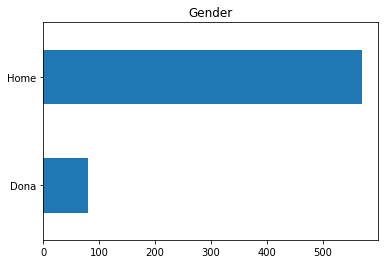

In [5]:
# data distribution by gender

_ = df['V1_sexe'].value_counts(ascending=True).plot(kind='barh', title='Gender')

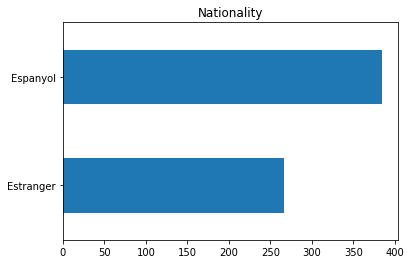

In [6]:
# data distribution by nationality

_ = df['V2_estranger'].value_counts(ascending=True).plot(kind='barh', title='Nationality')

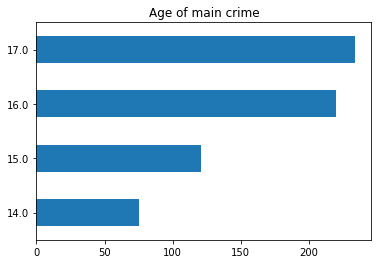

In [7]:
# data distribution by age

_ = df['V8_edat_fet'].value_counts(ascending=True).plot(kind='barh', title='Age of main crime')

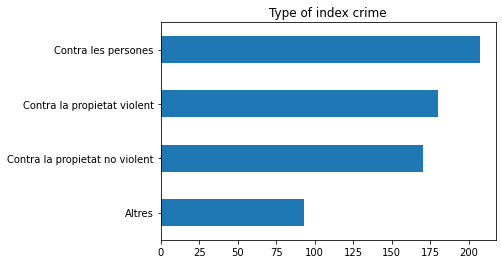

In [8]:
# data distribution by type of index crime

_ = df['V15_fet_agrupat'].value_counts(ascending=True).plot(kind='barh', title='Type of index crime')

## SAVRY model (human assessment)

The column `V56_@R1_resum_risc_global_reverse` is an evaluation done by a professional expert (that can be low, moderate, or high), based on the results of SAVRY but **applying his/her own judgment independently of the obtained score**.

The expert rates each defendant as "low", "medium", or "high" risk. Ideally, defendants considered low risk should recidivate at a lower rate than defendants considered high risk.

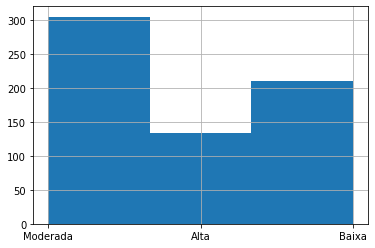

In [9]:
# human score distribution

hist = df['V56_@R1_resum_risc_global_reverse'].hist(bins=3)

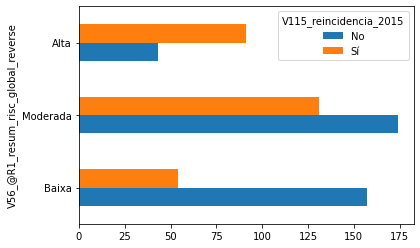

In [10]:
# human score distribution | recividism

human_ctable = pd.crosstab(df['V56_@R1_resum_risc_global_reverse'], df['V115_reincidencia_2015'])
human_ctable = human_ctable.reindex(index=["Baixa", "Moderada", "Alta"])
_ = human_ctable.plot(kind='barh')

In [11]:
# recividism rate per score

human_ctable["recidivism_rate"] = pd.Series(index=human_ctable.index, dtype='float')
for index, row in human_ctable.iterrows():
    recidivism_rate =row["Sí"] / (row["Sí"] + row["No"])
    human_ctable.at[index, "recidivism_rate"] = recidivism_rate
    
human_ctable

V115_reincidencia_2015,No,Sí,recidivism_rate
V56_@R1_resum_risc_global_reverse,,,
Baixa,157,54,0.255924
Moderada,174,131,0.429508
Alta,43,91,0.679104


### Baseline model

Our baseline prediction can be based on the column `V60_SAVRY_total_score`, which contains a sum of scores in the risk items of SAVRY. The max value of this sum is 40.

In [12]:
scores_recidivists = df[df["V115_reincidencia_2015"]=='Sí']["V60_SAVRY_total_score"].values
scores_non_recidivists = df[df["V115_reincidencia_2015"]=='No']["V60_SAVRY_total_score"].values

In [13]:
def compare_histograms(scores1, scores2, title, label1='Recidivists', label2='Non recidivists'):
    plt.figure(figsize=(10,6))
    plt.hist(scores1, histtype='step', label=label1, density=True, color='red')
    plt.hist(scores2, histtype='step', label=label2, density=True, color='blue')
    plt.legend(loc='upper right', fontsize='x-large')
    plt.ylabel('Probability')
    plt.xlabel(title)
    plt.show()

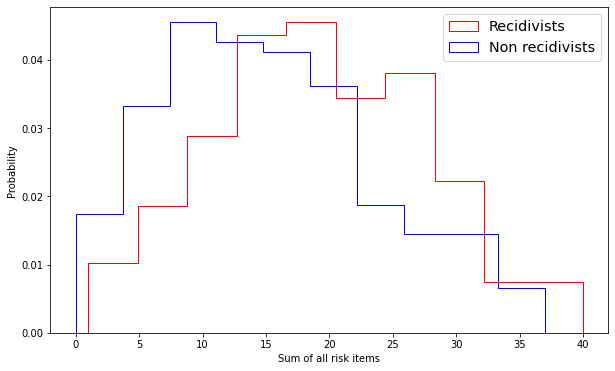

In [14]:
## baselin score distribution

compare_histograms(scores_recidivists, scores_non_recidivists, 'Sum of all risk items')

In [15]:
def draw_roc_curve( ground_truth, predictions, pos_label="Sí"):
    fpr, tpr, thresholds = roc_curve(ground_truth, predictions, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(10,6))
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right", fontsize='x-large')
    plt.show()
    return roc_auc

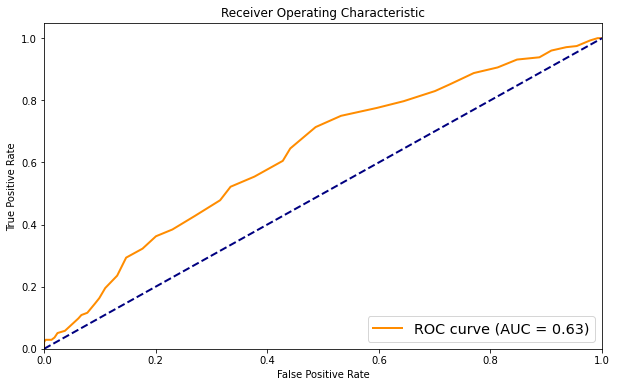

In [16]:
# Evaluation (ROC curve) of the baseline prediction

_ = draw_roc_curve(df["V115_reincidencia_2015"].values, df["V60_SAVRY_total_score"].values)

## Modeling recidivism using logistic regression

Logistic regression is a simple yet effective classification model for this problem.

In all cases above we will use the same training/testing split, which is done randomly, keeping 1/3 of the data for testing. You can repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [17]:
train, test = train_test_split(df, test_size=0.33)

### Modeling recidivism (24 risk factors)

Now we model recidivism by using the 24 risk factors in SAVRY.

Note that the performance depends on the training/testing split which is done randomly, keeping 1/3 of the data for testing. Repeat the following cells a couple of times to see how a different train/test split changes the AUC.

In [18]:
risk_factor_columns = list(df.columns)[70:94]

train_X = pd.get_dummies(train[risk_factor_columns])
train_y = train["V115_reincidencia_2015"]

test_X = pd.get_dummies(test[risk_factor_columns])
test_y = test["V115_reincidencia_2015"]

In [19]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [20]:
pred24_y = model.predict_proba(test_X)[:,1]
pred24_recidivists = pred24_y[test_y == 'Sí']
pred24_non_recidivists = pred24_y[test_y == 'No']

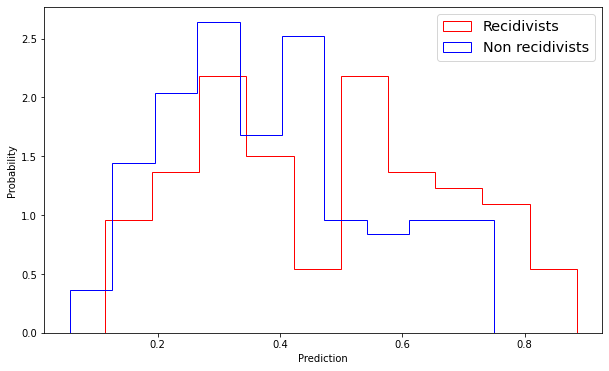

In [21]:
compare_histograms(pred24_recidivists, pred24_non_recidivists, 'Prediction')

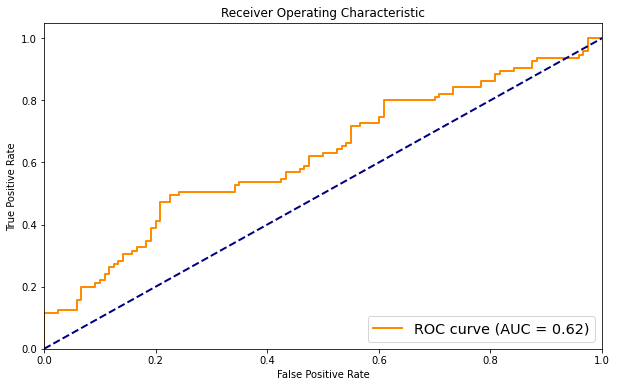

In [22]:
_ = draw_roc_curve(test_y, pred24_y)

### Modeling recidivism (personal history factors)

Next we use demographic factors: gender and nationality, as well as criminal history factors such as the age of commission of the index crime and its type, as well as whether the juvenile defendant has criminal records.

In [23]:
demographic_columns = ["V1_sexe", 
                       "V2_estranger", 
                       "V8_edat_fet", 
                       "V20_nombre_antecedents",
                       "V15_fet_agrupat", 
                       "V16_fet_violencia"]
                       
train_X = pd.get_dummies(train[demographic_columns])
train_y = train["V115_reincidencia_2015"]

test_X =  pd.get_dummies(test[demographic_columns])
test_y = test["V115_reincidencia_2015"]

In [24]:
model = LogisticRegression(solver='liblinear')
model.fit(train_X, train_y)

LogisticRegression(solver='liblinear')

In [25]:
predPH_y = model.predict_proba(test_X)[:,1]
predPH_recidivists = predPH_y[test_y == 'Sí']
predPH_non_recidivists = predPH_y[test_y == 'No']

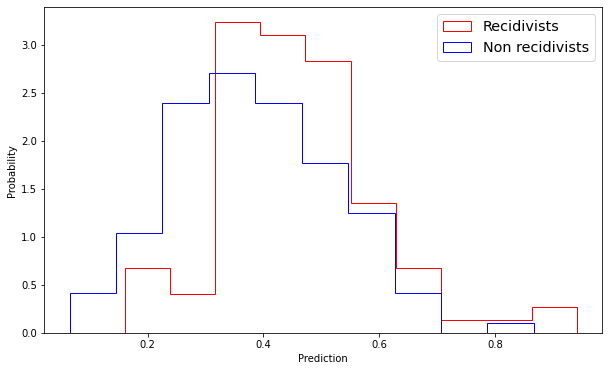

In [26]:
compare_histograms(predPH_recidivists, predPH_non_recidivists, 'Prediction')

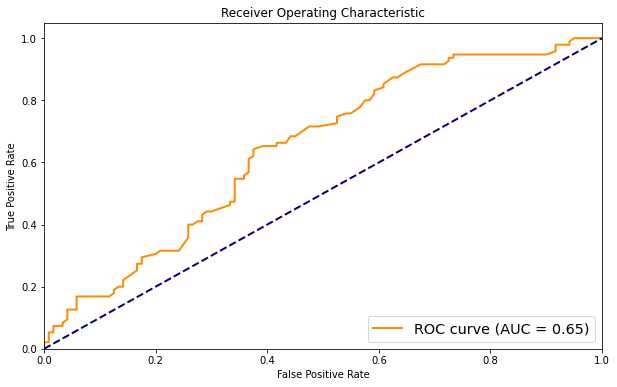

In [27]:
_ = draw_roc_curve(test_y, predPH_y)

### Modeling recidivism (personal history + 24 risk factors + 6 protective factors)

We now add to the above 6 "protective" or positive factors that are associated with a low risk.

In [28]:
protective_factor_columns = ["V89_@P1_impicacio_prosocial", 
                             "V90_@P2_suport_social_fort",
                             "V91_@P3_forta_vinculacio_adult_prosocial", 
                             "V92_@P4_actitud_positiva_intervencions_autoritat",
                             "V93_@P5_fort_compromis_escola_treball", 
                             "V94_@P6_perseverança_tret_personalitat"]

lr_factors = demographic_columns + risk_factor_columns + protective_factor_columns

lr_train_X = pd.get_dummies(train[lr_factors])
lr_train_y = train["V115_reincidencia_2015"]

lr_test_X = pd.get_dummies(test[lr_factors])
lr_test_y = test["V115_reincidencia_2015"]

In [29]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(lr_train_X, lr_train_y)

LogisticRegression(solver='liblinear')

In [30]:
predALL_y = lr_model.predict_proba(lr_test_X)[:,1]
predALL_recidivists = predALL_y[lr_test_y == 'Sí']
predALL_non_recidivists = predALL_y[lr_test_y == 'No']

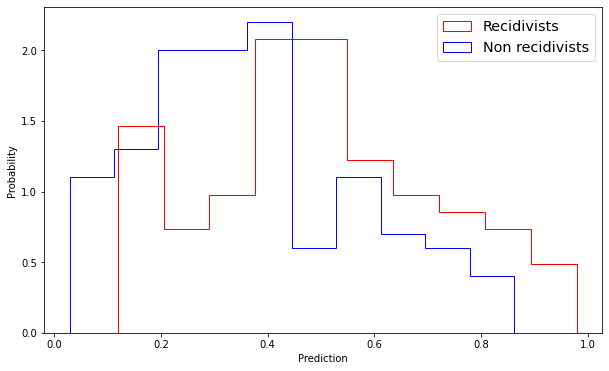

In [31]:
compare_histograms(predALL_recidivists, predALL_non_recidivists, 'Prediction')

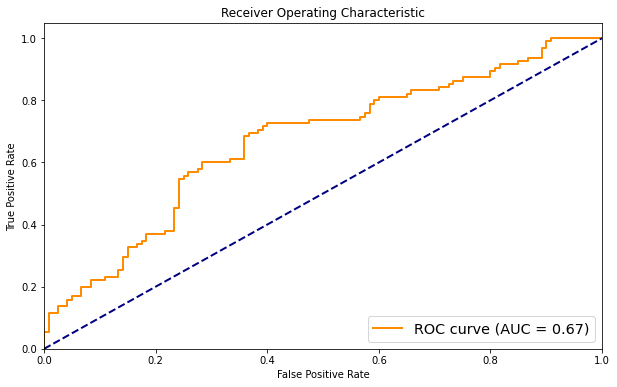

In [32]:
_ = draw_roc_curve(test_y, predALL_y)

# Recidivism and fairness
We remark that fairness is not necessarily that people in different groups obtain the same outcomes. For instance, in this dataset, women recidivate at about half the rate as men, and foreigners at a higher rate than nationals.

In [33]:
recidivism_by_gender = pd.crosstab(df["V115_reincidencia_2015"], df["V1_sexe"])
recidivism_by_gender['Dona'] = recidivism_by_gender['Dona'] / recidivism_by_gender['Dona'].sum()
recidivism_by_gender['Home'] = recidivism_by_gender['Home'] / recidivism_by_gender['Home'].sum()
recidivism_by_gender

V1_sexe,Dona,Home
V115_reincidencia_2015,,
No,0.759494,0.549912
Sí,0.240506,0.450088


In [34]:
recidivism_by_nationality = pd.crosstab(df["V115_reincidencia_2015"], df["V2_estranger"])
recidivism_by_nationality['Espanyol'] = recidivism_by_nationality['Espanyol'] / recidivism_by_nationality['Espanyol'].sum()
recidivism_by_nationality['Estranger'] = recidivism_by_nationality['Estranger'] / recidivism_by_nationality['Estranger'].sum()
recidivism_by_nationality

V2_estranger,Espanyol,Estranger
V115_reincidencia_2015,,
No,0.632812,0.492481
Sí,0.367188,0.507519


# Fairness as **equality of error rates**

We can look at fairness as **equality of error rates**.

## Professional (human expert) recidivism prediction and fairness

We consider people who did not recidivate, in particular, look at those who were given a "high" risk by the expert.

In [35]:
non_recidivists = df[df["V115_reincidencia_2015"] == 'No']
non_recidivists_expert_by_gender = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V1_sexe"])
non_recidivists_expert_by_gender.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_gender["Home"] = non_recidivists_expert_by_gender["Home"] / non_recidivists_expert_by_gender["Home"].sum()
non_recidivists_expert_by_gender["Dona"] = non_recidivists_expert_by_gender["Dona"] / non_recidivists_expert_by_gender["Dona"].sum()
non_recidivists_expert_by_gender

V1_sexe,Dona,Home
V56_@R1_resum_risc_global_reverse,,
Alta,0.116667,0.114650
Baixa,0.433333,0.417197
Moderada,0.450000,0.468153


In [36]:
non_recidivists_expert_by_nationality = pd.crosstab(non_recidivists["V56_@R1_resum_risc_global_reverse"], non_recidivists["V2_estranger"])
non_recidivists_expert_by_nationality.reindex(index=["Baix", "Moderat", "Alt"])
non_recidivists_expert_by_nationality["Espanyol"] = non_recidivists_expert_by_nationality["Espanyol"] / non_recidivists_expert_by_nationality["Espanyol"].sum()
non_recidivists_expert_by_nationality["Estranger"] = non_recidivists_expert_by_nationality["Estranger"] / non_recidivists_expert_by_nationality["Estranger"].sum()
non_recidivists_expert_by_nationality

V2_estranger,Espanyol,Estranger
V56_@R1_resum_risc_global_reverse,,
Alta,0.106996,0.129771
Baixa,0.423868,0.412214
Moderada,0.469136,0.458015


## Overall SAVRY score and fairness

In [37]:
scores_men_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                      (df["V1_sexe"]=='Home')]["V60_SAVRY_total_score"].values
scores_women_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V1_sexe"]=='Dona')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of men non-recidivist: %.2f" %
      (scores_men_non_recidivists.sum() / len(scores_men_non_recidivists)))
       
print("Average SAVRY score of women non-recidivist: %.2f" % 
      (scores_women_non_recidivists.sum() / len(scores_women_non_recidivists)))

Average SAVRY score of men non-recidivist: 15.38
Average SAVRY score of women non-recidivist: 15.67


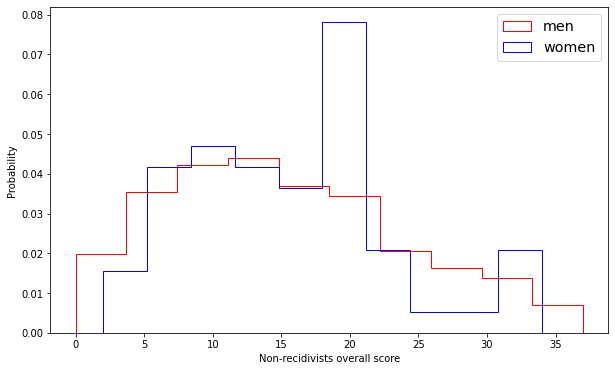

In [38]:
compare_histograms(scores_men_non_recidivists, scores_women_non_recidivists,
                   "Non-recidivists overall score",
                   label1="men", label2="women")

In [39]:
scores_nationals_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                      (df["V2_estranger"]=='Espanyol')]["V60_SAVRY_total_score"].values
scores_foreigners_non_recidivists = df[(df["V115_reincidencia_2015"]=='No') &
                                       (df["V2_estranger"]=='Estranger')]["V60_SAVRY_total_score"].values

print("Average SAVRY score of national non-recidivist: %.2f" %
      (scores_nationals_non_recidivists.sum() / len(scores_nationals_non_recidivists)))
       
print("Average SAVRY score of foreigner non-recidivist: %.2f" % 
      (scores_foreigners_non_recidivists.sum() / len(scores_foreigners_non_recidivists)))

Average SAVRY score of national non-recidivist: 14.84
Average SAVRY score of foreigner non-recidivist: 16.51


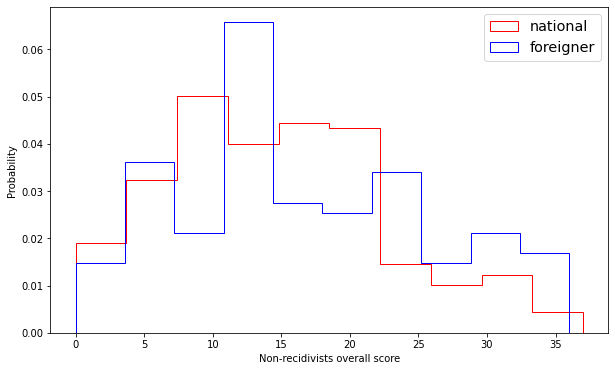

In [40]:
compare_histograms(scores_nationals_non_recidivists, scores_foreigners_non_recidivists,
                   "Non-recidivists overall score",
                   label1="national", label2="foreigner")

## Fairness using ML score

In [41]:
predPH_men_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
predPH_women_non_recidivists = predPH_y[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]

print("Average predicted probability of men non-recidivist: %.2f" %
      (predPH_men_non_recidivists.sum() / len(predPH_men_non_recidivists)))
       
print("Average predicted probability of women non-recidivist: %.2f" % 
      (predPH_women_non_recidivists.sum() / len(predPH_women_non_recidivists)))

Average predicted probability of men non-recidivist: 0.41
Average predicted probability of women non-recidivist: 0.19


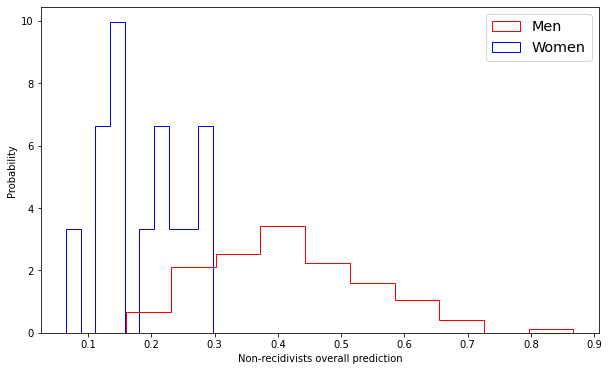

In [42]:
compare_histograms(predPH_men_non_recidivists, predPH_women_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Men", label2="Women")

In [43]:
predPH_nationals_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
predPH_foreigners_non_recidivists = predPH_y[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]

print("Average predicted probability of national non-recidivist: %.2f" %
      (predPH_nationals_non_recidivists.sum() / len(predPH_nationals_non_recidivists)))
       
print("Average predicted probability of foreigner non-recidivist: %.2f" % 
      (predPH_foreigners_non_recidivists.sum() / len(predPH_foreigners_non_recidivists)))

Average predicted probability of national non-recidivist: 0.33
Average predicted probability of foreigner non-recidivist: 0.49


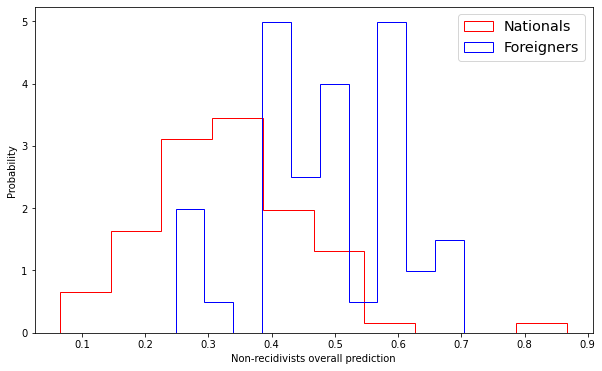

In [44]:
compare_histograms(predPH_nationals_non_recidivists, predPH_foreigners_non_recidivists,
                   "Non-recidivists overall prediction",
                   label1="Nationals", label2="Foreigners")

# Exercise 1

1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 
2. Check if they satisfy the proposed fairness criteria. 
3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 

### Questions (justify your answers)

1. Is there a method that can achieve better predictive power than human experts? 


2. Is this method better than human experts in terms of fairness?


3. Which is the most suited fairness criterium for this problem? Why?


4. What are your conclusion about the use of a ML model to predict recividism?



1. Use different machine learning models (SVM, Random Forests, etc.) to check if you can increase the performance of the logistic regression model. 

Based on the code found in https://towardsdatascience.com/model-design-and-selection-with-scikit-learn-18a29041d02a, we will perform grid search on a number of available models. Grid search will tune the hyperparameters in each model and give us the best configuration of all of them. That way, we may be able to select the best models in terms of performance.

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

In [46]:
# Define models that will be explored and considered. If I've got time enough, this list should increase in size.
classifiers = {}
classifiers.update({"RF": RandomForestClassifier()})
classifiers.update({"SVC": SVC()})
classifiers.update({"DTC": DecisionTreeClassifier()})

DECISION_FUNCTIONS = {"Ridge", "SGD", "LSVC", "NuSVC", "SVC"}
FEATURE_IMPORTANCE = {"Gradient Boosting", "Extra Trees Ensemble", "Random Forest"}

In [47]:
# Parameters for each model on which Grid Search will act to find the best configuration.
parameters = {}
parameters.update({"RF": { 
    "classifier__n_estimators": [200],
    "classifier__class_weight": [None, "balanced"],
    "classifier__max_features": ["auto", "sqrt", "log2"],
    "classifier__max_depth" : [3, 4, 5, 6, 7, 8],
    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
    "classifier__criterion" :["gini", "entropy"]     ,
    "classifier__n_jobs": [-1]
}})

parameters.update({"SVC": { 
    "classifier__kernel": ["linear", "rbf", "poly"],
    "classifier__gamma": ["auto"],
    "classifier__C": [0.1, 0.5, 1, 5, 10, 50, 100],
    "classifier__degree": [1, 2, 3, 4, 5, 6]
}})

parameters.update({"DTC": { 
    "classifier__criterion" :["gini", "entropy"],
    "classifier__splitter": ["best", "random"],
    "classifier__class_weight": [None, "balanced"],
    "classifier__max_features": ["auto", "sqrt", "log2"],
    "classifier__max_depth" : [1,2,3, 4, 5, 6, 7, 8],
    "classifier__min_samples_split": [0.005, 0.01, 0.05, 0.10],
    "classifier__min_samples_leaf": [0.005, 0.01, 0.05, 0.10],
}})

In [48]:
# Grid search routine
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn import metrics

results = {}

for classifier_label, classifier in classifiers.items():
    print(f"Now tuning {classifier_label}.")
    
    # Initialize Gridsearch
    scaler = StandardScaler()
    steps = [("scaler", scaler), ("classifier", classifier)] 
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
    gscv.fit(train_X, train_y)  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions, evaluate and save results
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(test_X)
    else:
        y_pred = gscv.predict_proba(test_X)[:,1]
    
    auc_score = metrics.roc_auc_score(test_y, y_pred)
    
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc_score,
              "Predictions": y_pred}
    
    results.update({classifier_label: result})

Now tuning RF.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Now tuning SVC.
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Now tuning DTC.
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits


After tuning all models, the scores for each one of them can be retrieved. Also, we will draw their respective ROC curves.

=== RF ===
Best score: 0.6784552199258082
AUC: 0.6456578947368421


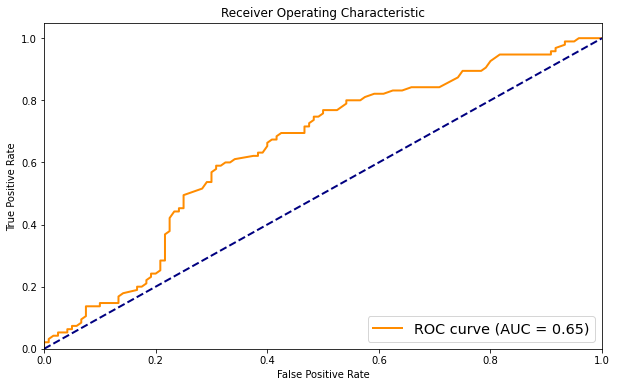

=== SVC ===
Best score: 0.6833118412530177
AUC: 0.6644736842105263


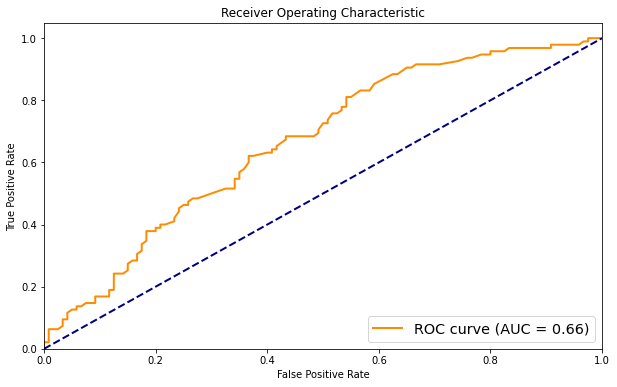

=== DTC ===
Best score: 0.6824572808102221
AUC: 0.6090350877192983


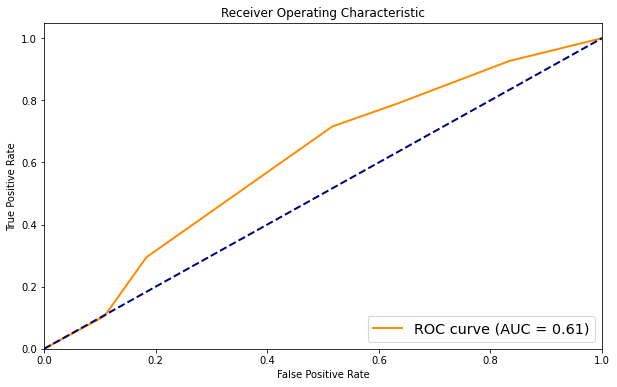

In [49]:
for model in results:
    print("===", model, "===")
    print("Best score:", results[model]["Training AUC"])
    print("AUC:", results[model]["Test AUC"])
    draw_roc_curve(test_y, results[model]["Predictions"])

(Context: Experiment performed with RF, SVC and DTC on 2022/05/02 18:28)

The AUC best score was obtained by 0.68 by SVC with the following parameters:

In [50]:
results["SVC"]["Best Parameters"]

{'classifier__C': 100,
 'classifier__degree': 1,
 'classifier__gamma': 'auto',
 'classifier__kernel': 'linear'}

The classifier is accessible through the following line of code:

In [51]:
results["SVC"]["Classifier"]

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        SVC(C=100, degree=1, gamma='auto',
                                            kernel='linear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': [0.1, 0.5, 1, 5, 10, 50, 100],
                         'classifier__degree': [1, 2, 3, 4, 5, 6],
                         'classifier__gamma': ['auto'],
                         'classifier__kernel': ['linear', 'rbf', 'poly']},
             scoring='roc_auc', verbose=1)

2. Check if they satisfy the proposed fairness criteria. 


The proposed fairness criteria is based on equality of error rates. We will imitate what is done in the given code.

In [52]:
fairness = pd.DataFrame({'Model': [],
                         'Men': [],
                         'Women': [],
                         'Gender Bias': [],      
                         'Spanish': [],
                         'Foreign': [],
                         'Nationality Bias': []})


# Restrict the predictions in terms of gender and nationality and compare the error rates
for model in results:
      pred = results[model]["Predictions"]
      pred[pred<0] = 0

      pred_men_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
      pred_men_recidivists = pred[(test_y=='Sí') & (test_X["V1_sexe_Home"]==1)]
      pred_women_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
      pred_women_recidivists = pred[(test_y=='Sí') & (test_X["V1_sexe_Dona"]==1)]
      pred_nationals_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
      pred_nationals_recidivists = pred[(test_y=='Sí') & (test_X["V2_estranger_Espanyol"]==1)]
      pred_foreigners_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]
      pred_foreigners_recidivists = pred[(test_y=='Sí') & (test_X["V2_estranger_Estranger"]==1)]

      man = (pred_men_non_recidivists.sum() + len(pred_men_recidivists) - pred_men_recidivists.sum()) / (len(pred_men_non_recidivists) + len(pred_men_recidivists))
      woman = (pred_women_non_recidivists.sum() + len(pred_women_recidivists) - pred_women_recidivists.sum()) / (len(pred_women_non_recidivists) + len(pred_women_recidivists))
      gender_bias = abs(man - woman)
      spanish = (pred_nationals_non_recidivists.sum() + len(pred_nationals_recidivists) - pred_nationals_recidivists.sum()) / (len(pred_nationals_non_recidivists) + len(pred_nationals_recidivists))
      foreign = (pred_foreigners_non_recidivists.sum() + len(pred_foreigners_recidivists) - pred_foreigners_recidivists.sum()) / (len(pred_foreigners_non_recidivists) + len(pred_foreigners_recidivists))
      nationality_bias = abs(foreign - spanish)

      fairness.loc[len(fairness.index)] = [model, man, woman, gender_bias, spanish, foreign, nationality_bias]

fairness

,Model,Men,Women,Gender Bias,Spanish,Foreign,Nationality Bias
0,RF,0.472489,0.404869,0.067619,0.452491,0.487921,0.035430
1,SVC,0.416254,0.277778,0.138476,0.405722,0.403099,0.002623
2,DTC,0.471215,0.496119,0.024904,0.453385,0.502599,0.049213


DTC works the best in terms of both gender, and SVC in nationality. See that, in general, DTC and RF have better performance than SVC.

3. Compare several fairness criteria, such as Demographic Parity, Equal Opportunity, Equalized Odds, and Conditional Demographic Parity. 


Demographic Parity requires us to get the same Positive Rate for each protected class.

In [53]:
# Data representation
fairness = pd.DataFrame({'Model': [],
                         'Men': [],
                         'Women': [],
                         'Gender Bias': [],      
                         'Spanish': [],
                         'Foreign': [],
                         'Nationality Bias': []})


# Restrict the predictions in terms of gender and nationality and compare the positive rates
for model in results:
      pred = results[model]["Predictions"]
      pred[pred<0] = 0
      pred_men_recidivists = pred[(test_X["V1_sexe_Home"]==1)]
      pred_women_recidivists = pred[(test_X["V1_sexe_Dona"]==1)]
      pred_nationals_recidivists = pred[(test_X["V2_estranger_Espanyol"]==1)]
      pred_foreigners_recidivists = pred[(test_X["V2_estranger_Estranger"]==1)]


      man = np.round(pred_men_recidivists).sum() / len(pred_men_recidivists)    
      woman = np.round(pred_women_recidivists).sum() / len(pred_women_recidivists)
      gender_bias = abs(man - woman)
      spanish = np.round(pred_nationals_recidivists).sum() / len(pred_nationals_recidivists)
      foreign = np.round(pred_foreigners_recidivists).sum() / len(pred_foreigners_recidivists)
      nationality_bias = abs(foreign - spanish)

      fairness.loc[len(fairness.index)] = [model, man, woman, gender_bias, spanish, foreign, nationality_bias]

fairness

,Model,Men,Women,Gender Bias,Spanish,Foreign,Nationality Bias
0,RF,0.263959,0.000000,0.263959,0.109375,0.436782,0.327407
1,SVC,0.111675,0.000000,0.111675,0.046875,0.183908,0.137033
2,DTC,0.629442,0.333333,0.296108,0.335938,1.000000,0.664062


Equal Opportunity requires us to get the same True Positive Rate for each protected class.

In [54]:
# Data representation
fairness = pd.DataFrame({'Model': [],
                         'Men': [],
                         'Women': [],
                         'Gender Bias': [],      
                         'Spanish': [],
                         'Foreign': [],
                         'Nationality Bias': []})


# Restrict the predictions in terms of gender and nationality and compare the true positive rates
for model in results:
      pred = results[model]["Predictions"]
      pred[pred<0] = 0
      pred_men_recidivists = pred[(test_y=='Sí') & (test_X["V1_sexe_Home"]==1)]
      pred_women_recidivists = pred[(test_y=='Sí') & (test_X["V1_sexe_Dona"]==1)]
      pred_nationals_recidivists = pred[(test_y=='Sí') & (test_X["V2_estranger_Espanyol"]==1)]
      pred_foreigners_recidivists = pred[(test_y=='Sí') & (test_X["V2_estranger_Estranger"]==1)]


      man = np.round(pred_men_recidivists).sum() / len(pred_men_recidivists)    
      woman = np.round(pred_women_recidivists).sum() / len(pred_women_recidivists)
      gender_bias = abs(man - woman)
      spanish = np.round(pred_nationals_recidivists).sum() / len(pred_nationals_recidivists)
      foreign = np.round(pred_foreigners_recidivists).sum() / len(pred_foreigners_recidivists)
      nationality_bias = abs(foreign - spanish)

      fairness.loc[len(fairness.index)] = [model, man, woman, gender_bias, spanish, foreign, nationality_bias]

fairness

,Model,Men,Women,Gender Bias,Spanish,Foreign,Nationality Bias
0,RF,0.300000,0.0,0.300000,0.173077,0.418605,0.245528
1,SVC,0.166667,0.0,0.166667,0.057692,0.279070,0.221377
2,DTC,0.744444,0.2,0.544444,0.480769,1.000000,0.519231


Equalized odds requires us to get the same True and False Positive Rates for all protected classes. As we analyzed the first requirement previously, we will just check the False Positive Rates.

In [55]:
# Data representation
fairness = pd.DataFrame({'Model': [],
                         'Men': [],
                         'Women': [],
                         'Gender Bias': [],      
                         'Spanish': [],
                         'Foreign': [],
                         'Nationality Bias': []})


# Restrict the predictions in terms of gender and nationality and compare the false positive rates
for model in results:
      pred = results[model]["Predictions"]
      pred[pred<0] = 0
      pred_men_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Home"]==1)]
      pred_women_non_recidivists = pred[(test_y=='No') & (test_X["V1_sexe_Dona"]==1)]
      pred_nationals_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Espanyol"]==1)]
      pred_foreigners_non_recidivists = pred[(test_y=='No') & (test_X["V2_estranger_Estranger"]==1)]


      man = np.round(pred_men_non_recidivists).sum() / len(pred_men_non_recidivists)    
      woman = np.round(pred_women_non_recidivists).sum() / len(pred_women_non_recidivists)
      gender_bias = abs(man - woman)
      spanish = np.round(pred_nationals_non_recidivists).sum() / len(pred_nationals_non_recidivists)
      foreign = np.round(pred_foreigners_non_recidivists).sum() / len(pred_foreigners_non_recidivists)
      nationality_bias = abs(foreign - spanish)

      fairness.loc[len(fairness.index)] = [model, man, woman, gender_bias, spanish, foreign, nationality_bias]

fairness

,Model,Men,Women,Gender Bias,Spanish,Foreign,Nationality Bias
0,RF,0.233645,0.000000,0.233645,0.065789,0.454545,0.388756
1,SVC,0.065421,0.000000,0.065421,0.039474,0.090909,0.051435
2,DTC,0.532710,0.384615,0.148095,0.236842,1.000000,0.763158


Take into account that 0.5 has been set as threshold to consider a prediction to be positive or negative. 


Also, we can witness the presence of negative values (< 0) for some predictions. This is especially notable in predictions for women by SVC. For this reason predictions are filtered and converted to 0 if they are negative. This may not be the most accurate approach, but definitely the fastest.

This last fact and the few amount of women lead some models to _overfit_ when it comes to female predictions.


1. Is there a method that can achieve better predictive power than human experts? 

This is hard to tell numerically in terms of accuracy because of how predictions were given by the expert. We have 3 classes (therefore, we can not divide in 'Yes' or 'No' as we did with the model predictions by rounding the values) and the most populated one is the middle ground (unsure, "Moderada". Therefore, it can not be ignored that easily).

I would imagine that yes, but as we have seen in class: the world is biased, the data will probably represent that bias, and therefore the model will learn that bias from data.

2. Is this method better than human experts in terms of fairness?

The fairness metrics we are computing are all in terms of the correctness of the predictions. For that reason, the hardships we have encountered answering question number 1 are still present now.

In any case, after dissecting the performances we can see that some models present less bias in some sections than the expert. However, it should be noted that the human bias is generally low and equally distributed across the "risk" classfications.

Finally, we should also consider that we have been lucky with this specific expert and that we may come across with an either racist or sexist "expert" in the future.

3. Which is the most suited fairness criterium for this problem? Why?

In my opinion, guiding myself from conclusions reached in https://towardsdatascience.com/how-to-define-fairness-to-detect-and-prevent-discriminatory-outcomes-in-machine-learning-ef23fd408ef2#:~:text=Demographic%20Parity%20states%20that%20the,%E2%80%9Cbeing%20shown%20the%20ad%E2%80%9D I would say the Equalised Odds is the best criterium in this case.

We are dealing with criminalism in Catalonia, and what is more important to us is to get the most accuracy as possible among all groups in a fair way. Also, if we switched the positive label, it could help with minimizing false positives (freeing people that will commit crimes again) which is of great interest to the population.

In other contexts, like USA, it would be more suitable to use Demographic Parity. Take into account that crime is generally and wrongly considered a racial issue, when it actually is a classist issue provoked by historic racial discrimination towards minority races. For this reason, it is important for us to "fix the world" and getting rid from that horrible heritage.

4. What are your conclusion about the use of a ML model to predict recividism?

I do not consider it should ever substitute human expertise, at least from what we know and have learnt so far, because humans have a bigger ability to ignore biases from data and take historical and contextual circumstances into account.

However, these models are a great guide for the experts and they can also be used as a control tool. Bias is present in the world because we, as humans, perpetuate it. Should any person considered an expert be a main bias perpetuator, some of the models we have seen with low enough biases will expose them.

# Exercise 2

We have seen that the bias in the data with respect to the protected features (sex, nationality) yields disparity between groups. To analyze the influence of data bias with respect to the protected features we can perform a comparison of the baseline, unrestricted data settings with one mitigation method that addresses these issues: equalized base rates (EBR). Differences in predictive performance, group fairness and the set of features, which are important for prediction, provide further insights in the role that these conditions play with respect to group fairness.

EBR assumes the following stratified oversampling procedure. Considering the input features $x$ and the outcomes $y$, a protected feature $f'$ has $I$ possible values corresponding to different groups: $\{g_1,…,g_I\}$, comprising a reference group $g_{ref}$. For each group $g_i$, different to the reference group, we compute the number of positive or negative condition samples $|S_i|$ we need to add to the training data, where $|S_i|$ is the absolute value of $S_i = P(x(f')=g_i)(P(y|x(f')=g_i) - P(y|x(f')=g_{ref}))$. 

If $S_i$ is negative then we add to the data $|S_i|$ negative condition samples $P(y=0| P(x(f')=g_i)$, while for $S_i$ positive we add $|S_i|$ positive condition samples $P(y=1| P(x(f')=g_i)$ of group $g_i$. This procedure yields equal base rates between the group $g_i$ and the reference group $g_{ref}$, namely $P(x(f')=g_i) = P(x(f')=g_{ref})$.

### Questions (justify your answers)

1. Is the application of this mitigation method sufficient to guarantee fair outcomes?

In my opinion, it will depend on the distributions on the dataset. Classes that are very misrepresented may need a huge oversampling. In that sense, without proper data augmentation techniques, we may be overfitting the model to certain samples.

Also, balancing the representations may ironically break the balance within the classes. Talking from experience, in Computer Vision it was needed to balance race, age, expression and emotion in a face picture dataset. Trying to obtain the same number of samples in all combinations was not only costful and kind of tricky (know how many samples and which samples to replicate), but also disappointing in results.

EBR should be able to help in some scenarios, but should not be taken for granted or be applied unconsciously. Guiding these techniques and adapting them to the inherent necessities of our dataset are always important considerations.

# Exercise 3

In order to see which fearures are important for different predictive models we can use ML explainability models. 

Apply ML explainability models to the (i) human risk assessment score, (ii) to the SAVRY baseline model, and (iii) to the best ML model (in terms of performance). 

### Questions

1. Which are the top ten most important features of each model?

2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

In [56]:
from itertools import islice

def take(n, iterable):
    "Return first n items of the iterable as a list"
    return list(islice(iterable, n))

1. Which are the top ten most important features of each model?


i) Top 10 most important features for human risk assessment score

In [317]:
# ?

ii) Top 10 most important features for SAVRY:

In [57]:
importances = lr_model.coef_[0]
features = lr_train_X.columns

top_features = {}
for i in range(len(features)):
    top_features[features[i]] = importances[i]

top_features = dict(sorted(top_features.items(), key=lambda item: item[1], reverse=True))
print(take(10, top_features.items()))


[('V1_sexe_Home', 0.672216910501935), ('V76_@12_rebuig_grup_iguals_Alt', 0.6658285891118647), ('V81_@17_actitud_negatives_Alt', 0.558001744857404), ('V15_fet_agrupat_Contra la propietat no violent', 0.46861559596560043), ('V2_estranger_Estranger', 0.42887206803413175), ('V78_@14_escassa_habilitat_pares_educar_Alt', 0.4232947370158884), ('V70_@6_exposicio_violencia_llar_Moderat', 0.4191910754159761), ('V79_@15_manca_suport_personal_social_Alt', 0.4183122319910701), ('V86_@22_problemes_concentracio_hiperactivitat_Moderat', 0.38655469846333934), ('V77_@13_estrés_incapacitat_enfrontar_dificultats_Baix', 0.3860103747257581)]


iii) Top 10 most important features for each model that has importances available:

In [58]:
features = train_X.columns

for model in results:
    print("===", model, "===")
    try:
        importances = results[model]["Classifier"].best_estimator_.named_steps['classifier'].feature_importances_

        top_features = {} 
        for i in range(len(features)):
            top_features[features[i]] = importances[i]

        top_features = dict(sorted(top_features.items(), key=lambda item: item[1], reverse=True))
        print(take(10, top_features.items()))
    except:
        print("Importances not available")



=== RF ===
[('V20_nombre_antecedents', 0.3444142938180502), ('V8_edat_fet', 0.19237028344501397), ('V2_estranger_Espanyol', 0.10322183971091925), ('V1_sexe_Dona', 0.09140359210292452), ('V2_estranger_Estranger', 0.08804243952604658), ('V1_sexe_Home', 0.06432939808525064), ('V15_fet_agrupat_Altres', 0.04058758152071886), ('V15_fet_agrupat_Contra la propietat violent', 0.02353812948376221), ('V15_fet_agrupat_Contra les persones', 0.01399874982843304), ('V15_fet_agrupat_Contra la propietat no violent', 0.012938456895610271)]
=== SVC ===
Importances not available
=== DTC ===
[('V8_edat_fet', 0.3705749368935252), ('V20_nombre_antecedents', 0.36026303734319415), ('V2_estranger_Espanyol', 0.2637973123743322), ('V15_fet_agrupat_Contra la propietat violent', 0.005364713388948364), ('V1_sexe_Dona', 0.0), ('V1_sexe_Home', 0.0), ('V2_estranger_Estranger', 0.0), ('V15_fet_agrupat_Altres', 0.0), ('V15_fet_agrupat_Contra la propietat no violent', 0.0), ('V15_fet_agrupat_Contra les persones', 0.0)]


2. Look at the features thar are important for the best ML model after the application of the equalized base rates (EBR) mitigation stratgey. Is there any difference?

In [59]:
train_X[train_X["V1_sexe_Dona"] == 0].groupby("V2_estranger_Estranger").size()

V2_estranger_Estranger
0    212
1    162
dtype: int64

In [60]:
train_X[train_X["V1_sexe_Dona"] == 1].groupby("V2_estranger_Estranger").size()

V2_estranger_Estranger
0    44
1    17
dtype: int64

So, we have:

|        | Spanish | Foreign | Totals |
|--------|---------|---------|--------|
| Man    | 208     | 172     | 380    |
| Woman  | 42      | 13      | 55     |
| Totals | 250     | 185     | 435    |

We need 7 times more women, more or less. But we should also compensate the difference between Spanish and foreign women.

4 times more Spanish women and 16 times more foreign women should be enough.


|        | Spanish | Foreign | Totals |
|--------|---------|---------|--------|
| Man    | 208     | 172     | 380    |
| Woman  | 168     | 208     | 376    |
| Totals | 376     | 380     | 756    |

In [61]:
train_X["target"] = train_y

In [62]:
spanish_women = train_X[(train_X["V1_sexe_Dona"] == 1) & (train_X["V2_estranger_Estranger"] == 0)]

for i in range(3):
    train_X = pd.concat([train_X, spanish_women])

In [63]:
foreign_women = train_X[(train_X["V1_sexe_Dona"] == 1) & (train_X["V2_estranger_Estranger"] == 1)]

for i in range(15):
    train_X = pd.concat([train_X, foreign_women])

In [64]:
train_y = train_X["target"]
train_X = train_X.drop(["target"], axis=1)

In [65]:
train_X.shape, train_y.shape

((822, 12), (822,))

Now the dataset is way more balanced. Let's retrieve the importances as we did before.

In [66]:
lr_model = LogisticRegression(solver='liblinear')
lr_model.fit(train_X, train_y)

importances = lr_model.coef_[0]
features = train_X.columns

top_features = {}
for i in range(len(features)):
    top_features[features[i]] = importances[i]

top_features = dict(sorted(top_features.items(), key=lambda item: item[1], reverse=True))
print(take(10, top_features.items()))

[('V1_sexe_Home', 0.9773580010860063), ('V15_fet_agrupat_Contra la propietat no violent', 0.5380268118603645), ('V2_estranger_Estranger', 0.43568192480289447), ('V16_fet_violencia_Violent', 0.42846885775423404), ('V15_fet_agrupat_Contra les persones', 0.3959964738304369), ('V16_fet_violencia_No violent', 0.2588078568187784), ('V2_estranger_Espanyol', 0.2515947897702403), ('V20_nombre_antecedents', 0.1621121541635196), ('V15_fet_agrupat_Contra la propietat violent', 0.032472383923945476), ('V8_edat_fet', -0.21340497880786324)]


Adding more women made it more important to be a man for predictions. Being a foreigner or not does not increase in importance. The kind of crime, in particular violent crimes, gains a lot of relevance.

In [67]:
results = {}

for classifier_label, classifier in classifiers.items():
    print(f"Now tuning {classifier_label}.")
    
    # Initialize Gridsearch
    scaler = StandardScaler()
    steps = [("scaler", scaler), ("classifier", classifier)] 
    pipeline = Pipeline(steps = steps)
    param_grid = parameters[classifier_label]
    
    gscv = GridSearchCV(pipeline, param_grid, cv = 5,  n_jobs= -1, verbose = 1, scoring = "roc_auc")
    gscv.fit(train_X, train_y)  
    
    # Get best parameters and score
    best_params = gscv.best_params_
    best_score = gscv.best_score_
    
    # Update classifier parameters and define new pipeline with tuned classifier
    tuned_params = {item[12:]: best_params[item] for item in best_params}
    classifier.set_params(**tuned_params)
            
    # Make predictions, evaluate and save results
    if classifier_label in DECISION_FUNCTIONS:
        y_pred = gscv.decision_function(test_X)
    else:
        y_pred = gscv.predict_proba(test_X)[:,1]
    
    auc_score = metrics.roc_auc_score(test_y, y_pred)
    
    result = {"Classifier": gscv,
              "Best Parameters": best_params,
              "Training AUC": best_score,
              "Test AUC": auc_score,
              "Predictions": y_pred}
    
    results.update({classifier_label: result})
    
features = train_X.columns

for model in results:
    print("===", model, "===")
    try:
        importances = results[model]["Classifier"].best_estimator_.named_steps['classifier'].feature_importances_

        top_features = {} 
        for i in range(len(features)):
            top_features[features[i]] = importances[i]

        top_features = dict(sorted(top_features.items(), key=lambda item: item[1], reverse=True))
        print(take(10, top_features.items()))
    except:
        print("Importances not available")


Now tuning RF.
Fitting 5 folds for each of 1152 candidates, totalling 5760 fits
Now tuning SVC.
Fitting 5 folds for each of 126 candidates, totalling 630 fits
Now tuning DTC.
Fitting 5 folds for each of 3072 candidates, totalling 15360 fits
=== RF ===
[('V20_nombre_antecedents', 0.3958531635339468), ('V8_edat_fet', 0.2579029961376487), ('V1_sexe_Home', 0.08364687476932367), ('V1_sexe_Dona', 0.07655805887478882), ('V2_estranger_Espanyol', 0.04363674847010667), ('V2_estranger_Estranger', 0.04316930374773414), ('V15_fet_agrupat_Contra les persones', 0.02322963780861171), ('V15_fet_agrupat_Contra la propietat violent', 0.019476948896117174), ('V16_fet_violencia_No violent', 0.01704198182888537), ('V15_fet_agrupat_Contra la propietat no violent', 0.01667085410232257)]
=== SVC ===
Importances not available
=== DTC ===
[('V20_nombre_antecedents', 0.48969730288261243), ('V8_edat_fet', 0.22557002250758393), ('V1_sexe_Home', 0.09739235161730128), ('V2_estranger_Estranger', 0.07308733051271414), 

The importance of different features stays almost the same in RF as before the balancing of classes. For DTC, being a Woman, Spanish or Foreign has no great changes in importance; meanwhile, the other features change notoriously.